<a href="https://colab.research.google.com/github/wqiu96/summer_project/blob/master/src/value_iter_dirichlet_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import time
start_time = time.time()
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jitclass
from numba import int64, float64

__Goal__

Implement value iteration on 1d HJB with Dirichlet data and verify with the explicit solution on Whittle’s “Flypaper”

__Ref__

- [1] Chap V.7 of [Roger and Williams 2000] 

- [2] P97, Example 4 of [Kushner and Dupuis 2001]

- [previous version](https://github.com/songqsh/foo1/blob/master/src/value_iter_dirichlet_1d.ipynb)


__Problem setup__

We want to solve a d-dimensions HJB
$$\inf_a \{\sum_{i=1}^db_i(x,a)  \frac{\partial v(x)}{\partial x_i}  + \frac 1 2 \sum_{i,j=1}^{d} \hat \sigma_{ij} \frac{\partial^2 v(x)}{\partial x_i \partial x_j} - \lambda v(x) + \ell(x,a)\} = 0, \quad \hbox{ where } \hat \sigma _{ij} = \sigma*\sigma^T , \sum_{i=1}^{d}x_i^2\leq1$$
with Dirichlet data
$$v(x_1,x_2,..,x_d) = g(x_1,x_2,..,x_d), \quad \hbox{ when } \sum_{i=1}^{d}x_i^2 = 1$$




__MDP discretization__

Approximation:
$$
\frac{\partial v(x)}{\partial x_i} \leftarrow \frac{v(x+e_ih)-v(x-e_ih)}{2h}
$$
when $i = j$
$$
\frac{\partial^2 v(x)}{\partial x_i^2} \leftarrow \frac{v(x+e_ih)-2v(x)+v(x-e_ih)}{h^2}
$$
when $i \neq j$
$$
\frac{\partial^2 v(x)}{\partial x_i^2} \leftarrow \frac{v(x+e_ih+e_jh)-v(x+e_ih-e_jh)-v(x-e_ih+e_jh)+v(x-e_ih-e_jh)}{4h^2}
$$
then
$$\inf_a \{v(x)(-\lambda-\sum_{i=1}^{d}\frac{\hat \sigma_{ii}}{h^2})+\sum_{i=1}^{d}v(x+e_ih)\frac{b_i(x,a)h+\sigma_{ii}}{2h^2}+\sum_{i=1}^{d}v(x-e_ih)\frac{-b_i(x,a)h+\sigma_{ii}}{2h^2}+    \\
\sum_{i,j=1,i\neq j}^{d}(v(x+e_ih+e_jh)-v(x+e_ih-e_jh)-v(x-e_ih+e_jh)+v(x-e_ih-e_jh))\frac{\hat \sigma_{ij}}{8h^2}+ \ell(x,a)\} = 0
$$
Set
$$
c_1 = \lambda+\sum_{i=1}^{d}\frac{\hat \sigma_{ii}}{h^2}
$$
$$
\Lambda = \frac{\sum_{i=1}^{d}\frac{\lambda h^2+\sigma_{ii}}{h^2}}{\sum_{i=1}^{d}\frac{\sigma_{ii}}{h^2}}=\frac{\lambda h^2+\sum_{i=1}^{d}{\sigma_{ii}}}{\sum_{i=1}^{d}\sigma_{ii}}
$$
Then
$$
p^h(x+e_ih|x_i, a_i) = \Lambda \cdot (\frac{b_i(x,a)h + \hat \sigma_{ii}}{2c_1h^2})
$$
$$
p^h(x-e_ih|x_i, a_i) = \Lambda \cdot (\frac{-b_i(x,a)h + \hat \sigma_{ii}}{2c_1h^2})
$$
$$
p^h(x \pm e_ih \pm e_jh|x_i, x_j) = \frac{\hat \sigma_{ij}}{8h^2}
$$
$$
 \hat \ell(x,a)=\frac{\ell(x,a)}{c_1}
$$
so 

$$
v(x) = \inf_a\{\sum_{i=1}^{d}p^h(x+e_ih|x_i, a_i)v(x+e_ih) +\sum_{i=1}^{d}p^h(x-e_ih|x_i, a_i)v(x-e_ih) \\
+ \sum_{i,j=1,i\neq j}^{d}(v(x+e_ih+e_jh)-v(x+e_ih-e_jh)-v(x-e_ih+e_jh)+v(x-e_ih-e_jh))p^h(x \pm e_ih \pm e_jh|x_i, x_j) + \hat \ell(x,a) \}
$$

__Example__
$$
\inf_a(a \bigtriangledown v + \frac 1 2 \bigtriangleup v +d + 2|x|^2 + \frac 1 2 |a| ^2)
$$

where
$$
v(x) = g(x) = -|x|^2 = -(x_1^2 + x_2^2 +...+x_d^2)\\
$$
In this case
$$
b(x,a) = (a_1, a_2,...,a_d) \\
\begin{equation*}
\hat \sigma =\begin{bmatrix}
1 & 0&\dots & 0\\
0 &1 &\dots &0\\
0 & 0 &\dots & 1
\end{bmatrix}_{d\times d}
\end{equation*}
$$
$$
\ell(x,a) = d + 2|x|^2 + \frac 1 2 |a|^2
$$
the exact solution is 
$$
v(x) =  -|x|^2 = -(x_1^2 + x_2^2 +...+x_d^2)
$$

__Rk__

There is essential difference of above MDP approximation using central FDM from the one
using upward FDM provided by P97 of [2].

In [0]:
#@guvectorize([(float64[:], float64)], '(n)->()')


In [0]:
#PDE to be solved
spec = [
    ('dim', int64),               # a simple scalar field
    ('NUM', int64),
    ('x_space',float64[:]),    # an array field
    ('a_space',float64[:]),
    ('sigma',float64[:,:]),
    ('s_val',float64[:,:]),
    ('q_table',float64[:,:,:,:]),
    ('LIM', int64),
    ('lambda_',float64),
    ('h',float64)
]
@jitclass(spec)
class pde():
  def __init__(self,dim,NUM):
    #pde config
    self.dim = dim
    
    self.NUM = NUM
    
    self.h = 1./self.NUM
    
    self.LIM = 1 #limit for state

    self.lambda_ = 0. #discount rate
    
    self.x_space = np.array([i*self.h for i in range(-self.NUM*self.LIM, (self.NUM+1)*self.LIM)])

    self.a_space = np.array([i*self.h for i in range(-self.NUM*self.LIM, (self.NUM+1)*self.LIM)])
    
    self.sigma = np.eye(self.dim) #diffusion coefficient matrix

    #self.s_val = np.random.random(self.x_space.size*np.ones(self.dim, np.int))
    self.s_val = np.zeros((2*NUM+1,2*NUM+1))
    #self.q_table = np.random.random(np.append(self.x_space.size*np.ones(self.dim, np.int), self.a_space.size*np.ones(self.dim, np.int)))
    self.q_table = np.zeros((2*NUM+1,2*NUM+1,2*NUM+1,2*NUM+1))
    #pde exact solution if available

  def drift(self,x,a):
     return a

  def run_cost(self,x,a):
     return self.dim + 2*np.sum(np.power(x,2)) + (1/2)*np.sum(np.power(a,2))
 
  def term_cost(self,x):
     return -np.sum(np.power(x,2))
    
  def diagonal(self,sigma):      # array.diagonal can not be used in jitclass
    res = np.zeros(sigma.shape[0])
    for i in range(sigma.shape[0]):
      res[i] = sigma[i,i]
    return res
    
  #transition probability
  #output is probability (np array) on del_ind_space 
  #central fdm

  def mdp_trans_prob_central(self,x,a,sigma):
    tp = []
    tp1 = []
    b_ = self.drift(x,a)

    c1 = self.lambda_ + np.sum(self.diagonal(self.sigma))/(self.h**2)
    Lambda = 1 + self.lambda_*(self.h**2)/np.sum(self.diagonal(self.sigma))

    tp.append(Lambda*((b_*self.h + self.diagonal(self.sigma))/(2*c1*self.h**2)))
    tp.append(Lambda*((-1*b_*self.h + self.diagonal(self.sigma))/(2*c1*self.h**2)))
    tp1.append(self.sigma/(8*c1*self.h**2))

    return tp,tp1
  
  def Dif_array(self,s_index):        #calculate s_val(x+e_i*h) and s_val(x-e_i*h)
    res_plus = np.zeros(self.dim)
    res_mius = np.zeros(self.dim)
    for i in range(self.dim):
      temp_plus = s_index.copy() #copy()!!!!!!! very important
      temp_mius = s_index.copy()
      temp_plus[i] = s_index[i] + 1
      temp_mius[i] = s_index[i] - 1
      res_plus[i] = self.s_val[temp_plus[0],temp_plus[1]]
      res_mius[i] = self.s_val[temp_mius[0],temp_mius[1]]
    return res_plus,res_mius

  def Dif_martix(self,s_index):        #calculate s_val(x+e_i*h-e_j*h), s_val(x-e_j*h+e_i*h), s_val(x+e_j*h+e_i*h), s_val(x-e_j*h-e_i*h)
    res_plus_plus = np.zeros((self.dim,self.dim))
    res_mius_mius = np.zeros((self.dim,self.dim))
    res_plus_mius = np.zeros((self.dim,self.dim))
    res_mius_plus = np.zeros((self.dim,self.dim))
    for i in range(self.dim):
      for j in range(self.dim):
        if i != j:
          temp_plus_plus = s_index.copy()
          temp_mius_mius = s_index.copy()
          temp_plus_mius = s_index.copy()
          temp_mius_plus = s_index.copy()

          temp_plus_plus[i] = s_index[i] + 1
          temp_plus_plus[j] = s_index[j] + 1

          temp_mius_mius[i] = s_index[i] - 1
          temp_mius_mius[j] = s_index[j] - 1

          temp_plus_mius[i] = s_index[i] + 1
          temp_plus_mius[j] = s_index[j] - 1

          temp_mius_plus[i] = s_index[i] - 1
          temp_mius_plus[j] = s_index[j] + 1

          res_plus_plus[i][j] = self.s_val[temp_plus_plus[0],temp_plus_plus[1]]
          res_mius_mius[i][j] = self.s_val[temp_mius_mius[0],temp_mius_mius[1]]
          res_plus_mius[i][j] = self.s_val[temp_plus_mius[0],temp_plus_mius[1]]
          res_mius_plus[i][j] = self.s_val[temp_mius_plus[0],temp_mius_plus[1]]
    res = res_plus_plus + res_mius_mius - res_plus_mius - res_mius_plus

    return res

  def mdp(self):
    #print('>>>>> q_table size is %i' %(self.q_table.size))

    #s_val and q-table terminal setup
    for i in range(self.s_val.size):  # visit all x States
      k = 0
      x_d = np.zeros(self.dim)          
      s_index = np.zeros(self.dim, dtype = np.int64)
      Limit = 0
      while k < self.dim:
        x_d[k] = self.x_space[(i//(self.x_space.size**k))%self.x_space.size]
        s_index[k] = (i//(self.x_space.size**k))%self.x_space.size
        Limit += self.x_space[(i//(self.x_space.size**k))%self.x_space.size]**2
        k += 1
      if (np.min(s_index) == 0) or (np.max(s_index) == (self.x_space.size - 1)): # visit the terminal condition, (0 in s_index) cannot be used in jitclass
        self.s_val[s_index[0],s_index[1]] = self.term_cost(x_d)   #tuple can not be used in jit or jitclass
        for j in range(self.a_space.size**self.dim):
          m = 0
          q_index = np.zeros(2*self.dim, dtype = np.int64)
          a_index = np.zeros(self.dim, dtype = np.int64)
          while m < self.dim:
            a_index[m] = (i//(self.a_space.size**m))%self.a_space.size
            m += 1
          q_index = np.hstack((s_index,a_index)) 
          self.q_table[q_index[0],q_index[1],q_index[2],q_index[3]] = self.term_cost(x_d)

  def value_iter(self, TOL, MAX_ITER):
    
    err_ = 1. #error init

    n_iter = 0 #iteration counter
    while err_>TOL and n_iter < MAX_ITER:
      pre_s_val = self.s_val.copy()
      
      for i in range(self.s_val.size):  # visit all x States
        k = 0
        x_d = np.zeros(self.dim)          
        s_index = np.zeros(self.dim, dtype = np.int64)
        Limit = 0
        while k < self.dim:
          x_d[k] = self.x_space[(i//(self.x_space.size**k))%self.x_space.size]
          s_index[k] = (i//(self.x_space.size**k))%self.x_space.size
          Limit += self.x_space[(i//(self.x_space.size**k))%self.x_space.size]**2
          k += 1
        if (np.min(s_index) == 0) or (np.max(s_index) == (self.x_space.size - 1)):
          continue
        for j in range(self.a_space.size**self.dim):
          m = 0
          q_index = np.zeros(2*self.dim, dtype = np.int64)
          a_index = np.zeros(self.dim, dtype = np.int64)
          a_ = np.zeros(self.dim)
          while m < self.dim:
            a_index[m] = (i//(self.a_space.size**m))%self.a_space.size
            a_[m] = self.a_space[(i//(self.a_space.size**m))%self.a_space.size]
            m += 1
          tp_,tp_1 = self.mdp_trans_prob_central(x_d, a_, self.sigma)
          c1 = self.lambda_ + np.sum(self.diagonal(self.sigma))/(self.h**2)
          res_plus,res_mins = self.Dif_array(s_index)
          res = self.Dif_martix(s_index)

          run_cost_ = (self.run_cost(x_d,a_))/c1
          Lambda = 1 + self.lambda_*(self.h**2)/np.sum(self.diagonal(self.sigma))
          q_index = np.hstack((s_index,a_index))
          self.q_table[q_index[0],q_index[1],q_index[2],q_index[3]] = (run_cost_ + np.sum(np.multiply(tp_[0],res_plus)) + np.sum(np.multiply(tp_[1],res_mins))+np.sum(np.multiply(res,tp_1[0])))/Lambda
        self.s_val[s_index[0],s_index[1]] = np.min(self.q_table[s_index[0],s_index[1]]) #sync q_table with s_val
      err_ = np.max(np.abs(pre_s_val - self.s_val))

      n_iter += 1
      #if np.mod(n_iter,10) == 0:
      #  print('iterated ' + str(n_iter)+';')

    return err_, n_iter


   

In [0]:
pde1 = pde(dim=2,NUM=10)
pde1.mdp()
err, n_iter = pde1.value_iter(0.01, 1000)

In [67]:
end_time = time.time()
print('elapsed time is %f seconds' %(end_time - start_time))

elapsed time is 20.401962 seconds


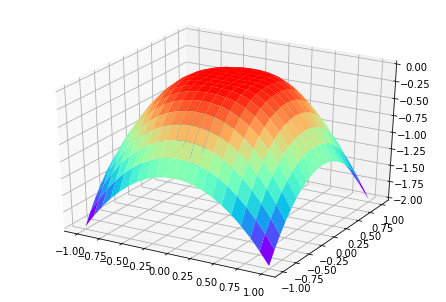

In [68]:
figure = plt.figure()
axes = Axes3D(figure)
X1 = pde1.x_space
X2 = pde1.x_space
X1, X2 = np.meshgrid(X1, X2)
Z1 = pde1.s_val
axes.plot_surface(X1, X2, Z1,cmap='rainbow')

>>>iteration error is 0.009769445897608364
>>>iter number is 24
>>>max norm of error is 0.17678567063480266
>>>Percentage of error is 0.10895433252634724


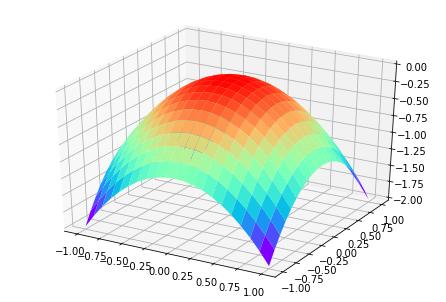

In [69]:
figure = plt.figure()
axes = Axes3D(figure)
X1 = pde1.x_space
X2 = pde1.x_space
X1, X2 = np.meshgrid(X1, X2)
Z = -(X1)**2 - (X2)**2
axes.plot_surface(X1, X2, Z,cmap='rainbow')
print('>>>iteration error is ' + str(err))
print('>>>iter number is ' + str(n_iter))
print('>>>max norm of error is ' + str(np.max(np.abs(Z-Z1))))
print('>>>Percentage of error is ' + str(np.sum(np.abs(Z-Z1))/np.sum(np.abs(Z))))